In [125]:
import re
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import hanlp
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
    
%matplotlib inline
mpl.rcParams['font.family'] = 'SimHei'

In [2]:
df = pd.read_excel('./data/data_train.xlsx')
df.sample(10)

,情感,语句,来源
137486,抱怨,唯一有点不满意的是，车窗会异响，不过后来去生活馆换了车窗的升降机之后异响就消失了。在这里要表...,开源数据集
56853,中性,赶紧找个珍惜你的男孩子嫁了吧,COLDataset
65089,中性,台湾人从小接受的教育就是如此，没办法,COLDataset
19722,投诉,进口宝马5系ID7车机缺少车主手册描述功能,车质网
32778,投诉,华晨宝马5系车机功能与厂家宣传不符,车质网
60528,中性,《求婚大作战》基本上算是日剧跑这个桥段的巅峰之作，男主山P在剧中每集都要玩命狂奔。甚至超越了...,COLDataset
15823,投诉,福建奔驰威霆发动机抖动加速无力,车质网
47638,中性,我们这些偏瘦的男士，一直再为120130的体重奋斗。,COLDataset
122754,表扬,就没什么满意的,开源数据集
9790,投诉,一汽奔腾T77多媒体屏幕黑屏4S店无法解决,车质网


In [3]:
print(f'样本数:{df.shape}')

样本数:(142834, 3)


类别：
抱怨    37153
表扬    35101
投诉    30508
中性    21881
辱骂    18191
Name: 情感, dtype: int64


Text(0.5, 1.0, '类别分布')

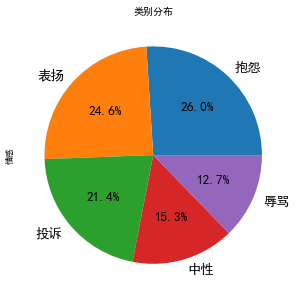

In [4]:
print(f"类别：\n{df['情感'].value_counts()}")

plt.figure(figsize = (6, 6), dpi = 60)
df['情感'].value_counts().plot.pie(autopct = '%1.1f%%', textprops = {'fontsize': 16}).set_title('类别分布')

In [5]:
print(f"缺失值分布：\n {df['语句'].isna().sum()}")

缺失值分布：
 3


In [6]:
df[df['语句'].isna()]

,情感,语句,来源
36723,中性,NaN,COLDataset
52766,辱骂,NaN,COLDataset
62669,辱骂,NaN,COLDataset


In [7]:
df = df.dropna()
print(f"缺失值分布：\n {df['语句'].isna().sum()}")
print(f'样本数:{df.shape}')

缺失值分布：
 0
样本数:(142831, 3)


In [100]:
# df['语句'].iloc[36723]
# # df['语句'][36723]

'葡币就是澳门元'

In [8]:
print(f"重复值：\n {df['语句'].duplicated().sum()}，比例：{np.round(100 * df['语句'].duplicated().sum() / len(df), 3)}%")

重复值：
 10743，比例：7.521%


In [9]:
df[df['语句'].duplicated() == True]['语句']  # 好奇怪？为啥会重复？

88                      价格要是能再低点就更好了！京东应该多搞特价活动!快递的服务态度不是很好
134          国产代工，电池部分设计不合理，装上电池后，与键盘平行的那一面有一点点高起来，有可能与屏接触。
194       我在买之前就看到很多人说装系统麻烦，果然不只一点点烦啊，一开始硬盘没找到。。。找了半天，不过...
262       六心电池装在后面突出一大块影响美观，速度慢机器有点卡，放歌一停顿一停顿，重量比一般的上网本重...
274       发热是普遍的，不过从07年我就开始使用的6515b的情况看，这个热是没有带来任何问题的，你不...
                                ...                        
142042                      动力稍稍有点不足，油耗有点小高，不知道是不是我不太会开的缘故。
142048    感觉北汽幻速车噪音还是有点的，不过慢慢习惯了就好了，特别是车子起步时候，踩上油门时候有明显感...
142056    最不满意的就是车子的动力还是有点不那么够用，一般家用的话应该是可以了，主要我是用来拉客偶尔也...
142179    虽然我是新手，但是油耗对于1.5l排量的车确实高，百公里差不多9个油，还有就是挂2档的时候，...
142552                                                 暂时没有
Name: 语句, Length: 10743, dtype: object

In [10]:
# 处理“6666”纯数字的文本
def handle_int(content):
    if type(content) == int:
        return str(content)
    return content

In [11]:
def remove_url(content):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', content)

In [12]:
df['语句'] = df['语句'].apply(lambda x: handle_int(x))
df['语句'] = df['语句'].apply(lambda x: remove_url(x))

In [13]:
hanlp.pretrained.tok.ALL

{'SIGHAN2005_PKU_CONVSEG': 'https://file.hankcs.com/hanlp/tok/sighan2005-pku-convseg_20200110_153722.zip',
 'SIGHAN2005_MSR_CONVSEG': 'https://file.hankcs.com/hanlp/tok/convseg-msr-nocrf-noembed_20200110_153524.zip',
 'CTB6_CONVSEG': 'https://file.hankcs.com/hanlp/tok/ctb6_convseg_nowe_nocrf_20200110_004046.zip',
 'PKU_NAME_MERGED_SIX_MONTHS_CONVSEG': 'https://file.hankcs.com/hanlp/tok/pku98_6m_conv_ngram_20200110_134736.zip',
 'LARGE_ALBERT_BASE': 'https://file.hankcs.com/hanlp/tok/large_corpus_cws_albert_base_20211228_160926.zip',
 'SIGHAN2005_PKU_BERT_BASE_ZH': 'https://file.hankcs.com/hanlp/tok/sighan2005_pku_bert_base_zh_20201231_141130.zip',
 'COARSE_ELECTRA_SMALL_ZH': 'https://file.hankcs.com/hanlp/tok/coarse_electra_small_20220616_012050.zip',
 'FINE_ELECTRA_SMALL_ZH': 'https://file.hankcs.com/hanlp/tok/fine_electra_small_20220615_231803.zip',
 'CTB9_TOK_ELECTRA_SMALL': 'https://file.hankcs.com/hanlp/tok/ctb9_electra_small_20220215_205427.zip',
 'CTB9_TOK_ELECTRA_BASE': 'http:/

In [14]:
tok = hanlp.load(hanlp.pretrained.tok.COARSE_ELECTRA_SMALL_ZH)

In [15]:
def tokenize(content):
    seg_list = tok(content)
    return ' '.join(seg_list)

In [16]:
df['text_splited'] = df['语句'].apply(tokenize)

In [18]:
df.sample(5)

,情感,语句,来源,text_splited,label
87751,表扬,说到满意，那止一点呀，多了去了，外观真心漂亮，各方面看都不失大体，虽然是小型suv，但空间宽...,开源数据集,说到 满意 ， 那 止 一点 呀 ， 多 了 去 了 ， 外观 真心 漂亮 ， 各 方面 看...,3
130042,抱怨,不满意的还真没有，如果说非要鸡蛋里挑骨头说一下不满意，那就是动力了，确实有点肉，不过个人觉得够用。,开源数据集,不 满意 的 还 真 没有 ， 如果说 非要 鸡蛋里挑骨头 说 一下 不 满意 ， 那 就 ...,2
92867,抱怨,倒挡回空挡得用很大的力，档位不顺畅,开源数据集,倒 挡回 空挡 得 用 很 大 的 力 ， 档位 不 顺畅,2
48,抱怨,明显能看出来是低端本，塑料感很强，做工也仅仅比神船稍好。usb只有2个，且都在左边。散热很差...,总部,明显 能 看 出来 是 低端本 ， 塑料感 很 强 ， 做工 也 仅仅 比 神船 稍 好 。...,2
131938,抱怨,顶篷布边沿处理简单,开源数据集,顶篷布 边沿 处理 简单,2


In [17]:
labels = LabelEncoder().fit(df['情感'])
df['label'] = labels.transform(df['情感'])

In [19]:
df['label'].value_counts()

2    37153
3    35101
1    30508
0    21880
4    18189
Name: label, dtype: int64

In [70]:
# 谨慎运行，这里会花很长时间
tfidf = TfidfVectorizer()
text_tfidf = tfidf.fit_transform(df['text_splited'])

In [71]:
# tfidf.get_feature_names()

In [110]:
RANDOM_SEED = 666

In [111]:
classifiers = {
    'LogisticRegression': LogisticRegression(random_state = RANDOM_SEED),
    'RidgeClassifier': RidgeClassifier(random_state = RANDOM_SEED)
}

lr_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    'max_iter': [50, 100, 200]
}

rd_grid = {
    'alpha': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5],
    'max_iter': [50, 100, 200]
}

grid_search_paramters = {
    'LogisticRegression': lr_grid,
    'RidgeClassifier': rd_grid
}

In [112]:
X = text_tfidf
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)
X_train_grid, X_val_grid, y_train_grid, y_val_grid = train_test_split(X_train, y_train, test_size = 0.1)

In [113]:
# clf_test = LogisticRegression()
# clf_test.fit(X_test[:100], y_test[:100])
# clf_test.predict(X_test[100: 200])

In [114]:
i = 0
clf_best_params = classifiers.copy()
valid_scores = pd.DataFrame({'Classifier': classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time (mins):': np.zeros(len(classifiers))})

In [115]:
for key, classifier in classifiers.items():
    start = time.time()
    
    clf = GridSearchCV(estimator = classifier, param_grid = grid_search_paramters[key], n_jobs = -1, cv = None)
    clf.fit(X_train_grid, y_train_grid)
    valid_scores.iloc[i, 1] = clf.score(X_val_grid, y_val_grid)
    
    clf_best_params[key] = clf.best_params_
    
    stop = time.time()
    valid_scores.iloc[i, 2] = np.round((stop - start) / 60, 3)
    
    print(f'Model: {key}')
    print(f'Training time (mins): {valid_scores.iloc[i, 2]}')
    print('')
    
    i += 1

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.p

Model: LogisticRegression
Training time (mins): 5.79

Model: RidgeClassifier
Training time (mins): 0.968



In [119]:
valid_scores

,Classifier,Validation accuracy,Training time (mins):
0,LogisticRegression,0.911875,5.790
1,RidgeClassifier,0.908375,0.968


In [120]:
clf_best_params

{'LogisticRegression': {'C': 1.5, 'max_iter': 200, 'penalty': 'l2'},
 'RidgeClassifier': {'alpha': 1.5, 'max_iter': 50}}

In [121]:
best_classifiers = {
    'LogisticRegression': LogisticRegression(**clf_best_params['LogisticRegression'], random_state = RANDOM_SEED)
}

In [133]:
FOLDS = 10
# preds = np.zeros(len(X_test))
X_final = X_train
y_final = np.array(y_train)
for key, classifier in best_classifiers.items():
    start = time.time()
    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = RANDOM_SEED)
    score = 0
    for fold , (train_idx, val_idx) in enumerate(cv.split(X_final, y_final)):
        X_train_cv, X_valid_cv = X_final[train_idx], X_final[val_idx]
        y_train_cv, y_valid_cv = y_final[train_idx], y_final[val_idx]
        
        classifier.fit(X_train_cv, y_train_cv)
        score += classifier.score(X_valid_cv, y_valid_cv)
#         preds += classifier.predict_proba(X_test)[:, 1]
    
    score = score / FOLDS
    stop = time.time()
    
    print(f'Model: {key}')
    print(f'Average validation accuracy: {np.round(100 * score, 3)}%')
    print(f'Training time (mins): {np.round((stop - start) / 60, 3)}')

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Model: LogisticRegression
Average validation accuracy: 91.313%
Training time (mins): (3.0, 3)


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
